In [1]:
import pandas as pd
%matplotlib inline

In [2]:
df = pd.read_csv("../../../mltestdata/self01_lstm/international-airline-passengers.csv")

In [3]:
df.head()

Month  \
0  1949-01   
1  1949-02   
2  1949-03   
3  1949-04   
4  1949-05   

   International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60  
0                                              112.0                               
1                                              118.0                               
2                                              132.0                               
3                                              129.0                               
4                                              121.0

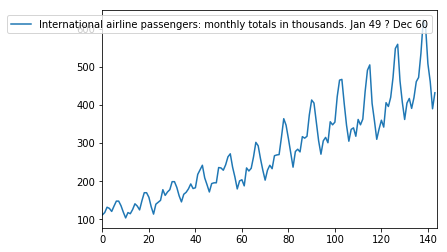

In [4]:
df.plot()

In [5]:
import numpy as np
import pandas as pd
import tflearn
import matplotlib.pyplot as plt

/usr/local/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)


# 学習させる

**乗客数のみ抽出**

In [6]:
dataframe = pd.read_csv('../../../mltestdata/self01_lstm/international-airline-passengers.csv',
        usecols=[1],
        engine='python',
        skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

**正規化**

In [7]:
dataset -= np.min(np.abs(dataset))
dataset /= np.max(np.abs(dataset))

** 訓練データとテストデータ **

localtrain, localval=train_test_split(train, test_size=0.25, random_state=2018)

drop_cols=['id','target']
y_localtrain=localtrain['target']
x_localtrain=localtrain.drop(drop_cols, axis=1)

y_localval=localval['target']
x_localval=localval.drop(drop_cols, axis=1)

In [8]:
def create_dataset(dataset, steps_of_history, steps_in_future):
    X, Y = [], []
    for i in range(0, len(dataset)-steps_of_history, steps_in_future):
        X.append(dataset[i:i+steps_of_history])
        Y.append(dataset[i + steps_of_history])
    X = np.reshape(np.array(X), [-1, steps_of_history, 1])
    Y = np.reshape(np.array(Y), [-1, 1])
    return X, Y

def split_data(x, y, test_size=0.1):
    pos = round(len(x) * (1 - test_size))
    trainX, trainY = x[:pos], y[:pos]
    testX, testY   = x[pos:], y[pos:]
    return trainX, trainY, testX, testY

steps_of_history = 1
#steps_of_history = 3

steps_in_future = 1
X, Y = create_dataset(dataset, steps_of_history, steps_in_future)
trainX, trainY, testX, testY = split_data(X, Y, 0.33)

**TFLearnでLSTMネットワークを構築**

(オプション)
- steps_of_historyでWindow幅を変えてみる。
- GRU(Gated Recurrent Unit)を使う
 - net = tflearn.lstm(net, n_units=6) の部分を net = tflearn.gru(net, n_units=6)に変更するだけ。
- GRUの層を増やしてみる
 - return_seqパラメーターをTrueにして2つ繋げてみる。
  - net = tflearn.gru(net, n_units=6)の部分を
  - net = tflearn.gru(net, n_units=6, return_seq=True)
  - net = tflearn.gru(net, n_units=6)

In [9]:
net = tflearn.input_data(shape=[None, steps_of_history, 1])

# LSTM
#net = tflearn.lstm(net, n_units=6)

# GRU
#net = tflearn.gru(net, n_units=6)

# GRU : Add one more layer
net = tflearn.gru(net, n_units=6, return_seq=True)
net = tflearn.gru(net, n_units=6)

net = tflearn.fully_connected(net, 1, activation='linear')
net = tflearn.regression(net, optimizer='adam', learning_rate=0.001,
        loss='mean_square')

model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(trainX, trainY, validation_set=0.1, batch_size=1, n_epoch=150)

Training Step: 12899  | total loss: 0.00121 | time: 0.213s
| Adam | epoch: 150 | loss: 0.00121 -- iter: 85/86
Training Step: 12900  | total loss: 0.00113 | time: 1.244s
| Adam | epoch: 150 | loss: 0.00113 | val_loss: 0.00233 -- iter: 86/86
--


# 時系列分析での予測精度の指標

In [10]:
def rmse(y_pred, y_true):
    return np.sqrt(((y_true - y_pred) ** 2).mean())

def rmsle(y_pred, y_true):
    return np.sqrt(np.square(np.log(y_true + 1) - np.log(y_pred + 1)).mean())

def mae(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred)))

def mape(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

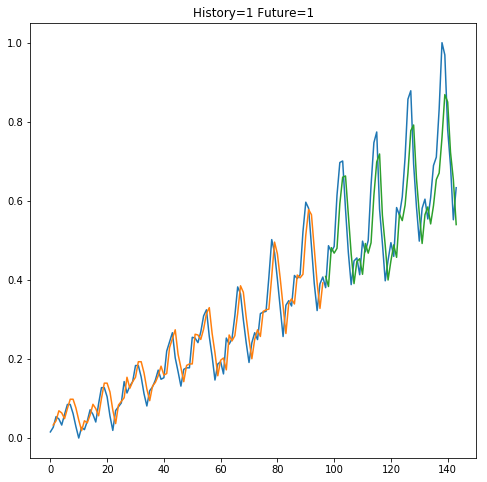

In [11]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[steps_of_history:len(train_predict)+steps_of_history, :] = \
        train_predict

test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+steps_of_history:len(dataset), :] = \
        test_predict

plt.figure(figsize=(8, 8))
plt.title('History={} Future={}'.format(steps_of_history, steps_in_future))
plt.plot(dataset)
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.savefig('passenger_gru1.png')

# TensorBoardで誤差を可視化する

In [10]:
#00model = tflearn.DNN(net, tensorboard_verbose=0)